# Sales Prediction

L'obiettivo di questo progetto è di utilizzare i dati proprietari del retailer [Leroy Merlin](https://www.leroymerlin.it/) in ottica di creazione di un vantaggio competitivo rispetto ai concorrenti, sfruttando le potenzialità della [Data Science](https://en.wikipedia.org/wiki/Data_science) in campo predittivo.

<center><img width="60%" src="https://dv-website.s3.amazonaws.com/uploads/2016/10/pg_2017ds_110116.png"></center>

Vediamo come procedere!

In [ ]:
# importing the useful packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import datetime as dt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore")
sns.set_style()
%matplotlib inline

# importing statements for plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

I dati sono storati in [BigQuery](https://en.wikipedia.org/wiki/BigQuery) all'interno della [Google Cloud Platform](https://en.wikipedia.org/wiki/Google_Cloud_Platform). Il dataset contiene le vendite del retailer dal 2018 al 2019.

### Data Dictionary
* `InvoiceDate`- Data della vendita.
* `StockCode`- Codice Prodotto.
* `Description` - Descrizione Prodotto.
* `Quantity` - Quantità di prodotto venduto.
* `UnitPrice` - Prezzo all'unità di prodotto.
* `Store` - Negozio relativo alla vendita.

In [ ]:
# connecting colab to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# importing data from 2018
path = ('/content/gdrive/MyDrive/sales_forecast_prophet/year_2018.csv')
year18 = pd.read_csv(path, encoding='latin-1')

# checking the dataset
year18.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice
0,2018-04-02,35572810,FIUMICINO,25.0,0.70
1,2018-04-02,36301685,FIUMICINO,1.0,19.95
2,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75
3,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90
4,2018-04-02,34921481,FIUMICINO,1.0,9.90


In [ ]:
# importing data from 2019
path = ('/content/gdrive/MyDrive/sales_forecast_prophet/year_2019.csv')
year19 = pd.read_csv(path, encoding='latin-1')

# checking the dataset
year19.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice
0,2019-11-30,35879935,ROMA SALARIA,2.0,1.15
1,2019-11-30,32175766,ROMA SALARIA,1.0,13.49
2,2019-10-05,35085666,ROMA SALARIA,4.0,0.31
3,2019-11-16,81251635,ROMA SALARIA,1.0,13.99
4,2019-11-16,35874321,ROMA SALARIA,1.0,0.52


In [ ]:
# importing data related to the stock codes
path = ('/content/gdrive/MyDrive/sales_forecast_prophet/StockCode.csv')
sc = pd.read_csv(path, encoding='latin-1')

# checking the dataset
sc.head()

,StockCode,Description
0,35292453,*APPL CESENA IP44 E27MAX60W NERO
1,30809345,*RIPIANO 100X40 7/10 GR.MRT
2,35760235,*COPRIWATER COLIBRI2 MDF BIANCO
3,36264711,*SOSP MUDA ALLUMINIO L90 21W LED 1720LM
4,32003685,*#PLAFONONIERA PER MURO RED 100X30


In [ ]:
# merging the 2 datasets
df=pd.merge(year18,year19, on=['InvoiceDate', 'StockCode', 'Store', 'Quantity', 'UnitPrice'], how='outer')
df=pd.merge(df,sc, on=['StockCode'], how='left')

df.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice,Description
0,2018-04-02,35572810,FIUMICINO,25.0,0.70,*SUPPORTO 3M NEA
1,2018-04-02,36301685,FIUMICINO,1.0,19.95,"*KIT STRISCIA LED NAT 1,5MT+DRIVER 4.5MT"
2,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75,*#PLAFONIERA PER MURO RED 150X50
3,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90,*APPL CESENA IP44 E27MAX60W NERO
4,2018-04-02,34921481,FIUMICINO,1.0,9.90,*CARTONE ONDULATO 1X45 MT


In [ ]:
# checking the shape of the dataset
print('Features:', df.shape[1])
print('Entries:', df.shape[0])

Features: 6
Entries: 20619591


In [ ]:
# checking for missing data and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20619591 entries, 0 to 20619590
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   InvoiceDate  object 
 1   StockCode    int64  
 2   Store        object 
 3   Quantity     float64
 4   UnitPrice    float64
 5   Description  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ GB


In [ ]:
# checking for missing values
(df.isnull().sum()/ df.shape[0]).sort_values(ascending=False)

Description    0.0
UnitPrice      0.0
Quantity       0.0
Store          0.0
StockCode      0.0
InvoiceDate    0.0
dtype: float64

In caso di anomalie, è bene assicurarsi che il dataset sia pulito.

In [ ]:
df_clean = df.copy()

df_clean.dropna(axis=0, inplace=True)

df_clean.index = pd.to_datetime(df_clean['InvoiceDate'])

df_clean.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice,Description
InvoiceDate,,,,,,
2018-04-02,2018-04-02,35572810,FIUMICINO,25.0,0.70,*SUPPORTO 3M NEA
2018-04-02,2018-04-02,36301685,FIUMICINO,1.0,19.95,"*KIT STRISCIA LED NAT 1,5MT+DRIVER 4.5MT"
2018-04-02,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75,*#PLAFONIERA PER MURO RED 150X50
2018-04-02,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90,*APPL CESENA IP44 E27MAX60W NERO
2018-04-02,2018-04-02,34921481,FIUMICINO,1.0,9.90,*CARTONE ONDULATO 1X45 MT


In [ ]:
# checking for missing values
(df_clean.isnull().sum()/ df_clean.shape[0]).sort_values(ascending=False)

Description    0.0
UnitPrice      0.0
Quantity       0.0
Store          0.0
StockCode      0.0
InvoiceDate    0.0
dtype: float64

In [ ]:
# fixing Quantity to be only positive
df_clean = df_clean[df_clean.Quantity > 0]

In [ ]:
# converting to upper case
df_clean['Description'] = df_clean.Description.str.upper()

In [ ]:
# getting some info
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19855253 entries, 2018-04-02 to 2019-07-10
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   InvoiceDate  object 
 1   StockCode    int64  
 2   Store        object 
 3   Quantity     float64
 4   UnitPrice    float64
 5   Description  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


Iniziamo ad esplorare i nostri dati.

### Nuove funzionalità

La creazione di nuove funzionalià è una delle attività per arricchire il dataset a disposizione, ad esempio con Quantity e UnitPrice è possibile calcolare l'importo speso per ogni prodotto.

In [ ]:
# creating a new feature
df_clean['AmountSpent'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [ ]:
# checking the data
df_clean.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice,Description,AmountSpent
InvoiceDate,,,,,,,
2018-04-02,2018-04-02,35572810,FIUMICINO,25.0,0.70,*SUPPORTO 3M NEA,17.50
2018-04-02,2018-04-02,36301685,FIUMICINO,1.0,19.95,"*KIT STRISCIA LED NAT 1,5MT+DRIVER 4.5MT",19.95
2018-04-02,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75,*#PLAFONIERA PER MURO RED 150X50,5.75
2018-04-02,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90,*APPL CESENA IP44 E27MAX60W NERO,23.60
2018-04-02,2018-04-02,34921481,FIUMICINO,1.0,9.90,*CARTONE ONDULATO 1X45 MT,9.90


## Data Exploration

L'esplorazione dei dati è fondamentale per comprenderne la struttura ed il valore intrinseco. Giochiamoci un pò!

In [ ]:
# statistical distribution of the data
df_clean.describe()

,StockCode,Quantity,UnitPrice,AmountSpent
count,1.985525e+07,1.985525e+07,1.985525e+07,1.985525e+07
mean,3.820078e+07,2.020951e+00,1.421368e+01,2.029201e+01
std,1.276069e+07,3.533173e+00,2.584177e+01,5.004801e+01
min,9.135510e+05,4.000000e-03,0.000000e+00,0.000000e+00
25%,3.376384e+07,1.000000e+00,2.600000e+00,3.650000e+00
50%,3.542643e+07,1.000000e+00,6.350000e+00,8.900000e+00
75%,3.590180e+07,2.000000e+00,1.499000e+01,2.090000e+01
max,8.249243e+07,2.001000e+03,1.350000e+03,1.172300e+05


### Punti salienti
* "Prezzo"
   * Il prezzo minimo è € 0,00, il che significa che il negozio può scontare alcuni prodotti in determinate circostanze.
   * Il prezzo medio dei prodotti è di € 25,84.
   * L'articolo più costoso costa € 1.350,00.
   * Anche se ci sono articoli costosi, la maggior parte sono economici: al 50esimo percentile il prezzo è di € 6,35 (inferiore alla media).

In [ ]:
# statistical distribution of categorical features
df_clean.describe(include='O')

,InvoiceDate,Store,Description
count,19855253,19855253,19855253
unique,720,49,2103
top,2019-12-27,PORTA DI ROMA,*MORSETTO UNIPOLARE 6 MMQ 10 POLI
freq,44042,618033,79187


#### Prodotti maggior vendenti


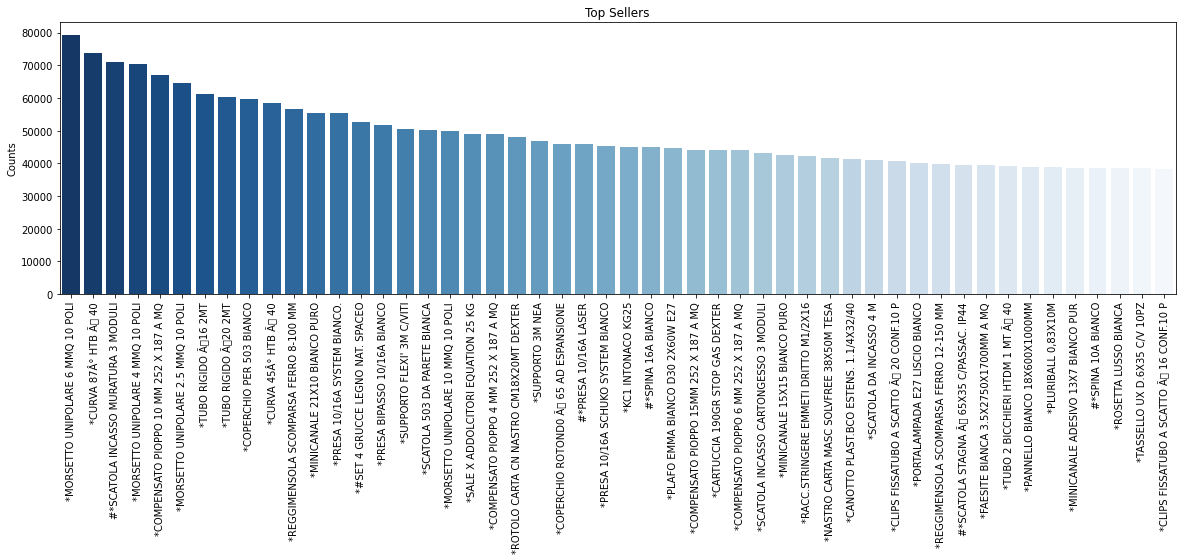

In [ ]:
# checking best selling products
Description_counts = df_clean.Description.value_counts().sort_values(ascending=False).iloc[0:50]
plt.figure(figsize=(20,5))
sns.barplot(Description_counts.index, Description_counts.values, palette='Blues_r')
plt.ylabel("Counts")
plt.title("Top Sellers");
plt.xticks(rotation=90);

#### Negozi maggior vendenti

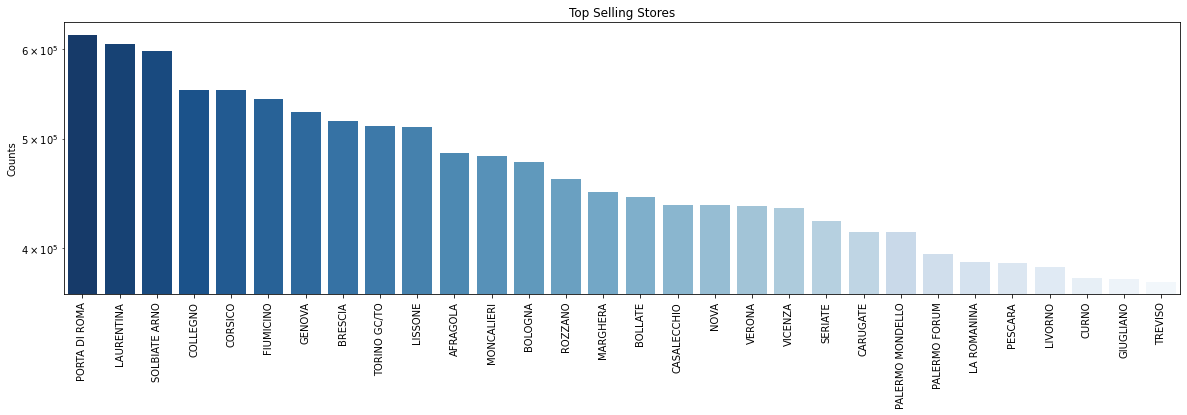

In [ ]:
# best selling stores
Store_counts = df_clean.Store.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(Store_counts.index, Store_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.title("Top Selling Stores");
plt.xticks(rotation=90);
plt.yscale("log")

## Time Series Analysis

<center><img width="60%" src="https://fbf.eui.eu/wp-content/uploads/2018/05/18-11-05-Forecasting.jpg"></center>


Abbiamo a che fare con le serie temporali, ovvero sequenze di osservazioni registrate in un periodo di tempo regolare.

Nella fattispecie stiamo analizzando vendite di prodotti in un determinato periodo di tempo.

### Applicazioni reali di business

Il dataset è utile al duplice scopo di:
* analizzare nei passato quali sono stati i trend di vendita (Business Intelligence)
* mettere a frutto le insight raccolte dai dati per fare previsioni future (Data Science)

Tali predizioni sono al netto di fattori esterni quali condizioni meteorologiche, disastri, etc. Tuttavia, possono essere una fonte affidabile di informazioni, che può supportare il management nel decision making.

Vediamo come lavorare con il Machine Learning!

In [ ]:
# Helping Time Series Analysis by creating some new features
df_clean["Year"] = df_clean.index.year
df_clean["Quarter"] = df_clean.index.quarter
df_clean["Month"] = df_clean.index.month
df_clean["Week"] = df_clean.index.week
df_clean["Weekday"] = df_clean.index.weekday
df_clean["Day"] = df_clean.index.day
df_clean["Dayofyear"] = df_clean.index.dayofyear
df_clean["Date"] = pd.DatetimeIndex(df_clean.index).date

# checking these features
df_clean.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice,Description,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
InvoiceDate,,,,,,,,,,,,,,,
2018-04-02,2018-04-02,35572810,FIUMICINO,25.0,0.70,*SUPPORTO 3M NEA,17.50,2018,2,4,14,0,2,92,2018-04-02
2018-04-02,2018-04-02,36301685,FIUMICINO,1.0,19.95,"*KIT STRISCIA LED NAT 1,5MT+DRIVER 4.5MT",19.95,2018,2,4,14,0,2,92,2018-04-02
2018-04-02,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75,*#PLAFONIERA PER MURO RED 150X50,5.75,2018,2,4,14,0,2,92,2018-04-02
2018-04-02,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90,*APPL CESENA IP44 E27MAX60W NERO,23.60,2018,2,4,14,0,2,92,2018-04-02
2018-04-02,2018-04-02,34921481,FIUMICINO,1.0,9.90,*CARTONE ONDULATO 1X45 MT,9.90,2018,2,4,14,0,2,92,2018-04-02


In [ ]:
# converting variables to either 0 or 1
df_clean['Weekend'] = 0
df_clean.loc[(df_clean.Weekday == 5) | (df_clean.Weekday == 6), 'Weekend'] = 1

In [ ]:
# checking the data
df_clean.head()

,InvoiceDate,StockCode,Store,Quantity,UnitPrice,Description,AmountSpent,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,Weekend
InvoiceDate,,,,,,,,,,,,,,,,
2018-04-02,2018-04-02,35572810,FIUMICINO,25.0,0.70,*SUPPORTO 3M NEA,17.50,2018,2,4,14,0,2,92,2018-04-02,0
2018-04-02,2018-04-02,36301685,FIUMICINO,1.0,19.95,"*KIT STRISCIA LED NAT 1,5MT+DRIVER 4.5MT",19.95,2018,2,4,14,0,2,92,2018-04-02,0
2018-04-02,2018-04-02,32003720,PORTA DI ROMA,1.0,5.75,*#PLAFONIERA PER MURO RED 150X50,5.75,2018,2,4,14,0,2,92,2018-04-02,0
2018-04-02,2018-04-02,35292453,PORTA DI ROMA,4.0,5.90,*APPL CESENA IP44 E27MAX60W NERO,23.60,2018,2,4,14,0,2,92,2018-04-02,0
2018-04-02,2018-04-02,34921481,FIUMICINO,1.0,9.90,*CARTONE ONDULATO 1X45 MT,9.90,2018,2,4,14,0,2,92,2018-04-02,0


Analizziamo le vendite nel weekend.

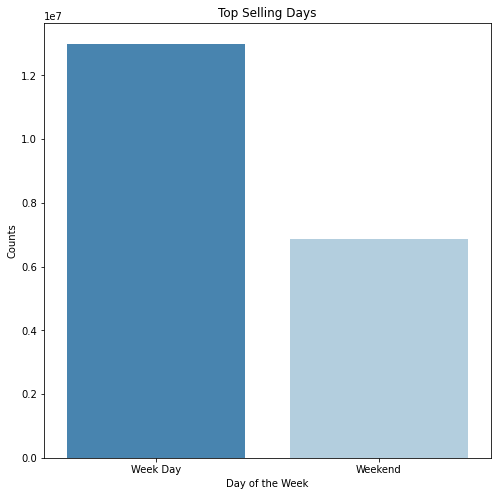

In [ ]:
# checking values for weekdays and weekends
weekend_counts = df_clean.Weekend.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(weekend_counts.index, weekend_counts.values, palette="Blues_r")
plt.ylabel("Counts")
plt.xlabel("Day of the Week")
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = 'Weekend'
labels[0] = 'Week Day'
ax.set_xticklabels(labels)
plt.title("Top Selling Days");

Il retailer vende quasi il doppio dei prodotti durante la settimana che nel weekend (5 gg feriali vs 2 gg weekend), in media:
* 70.000 articoli al giorno nei fine settimana
* 130.000 articoli al giorno nei giorni feriali


Concentriamoci adesso sulle vendite giornaliere.

In [ ]:
# creating grouped features
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

In [ ]:
# creating daily features
daily_data = pd.DataFrame(df_clean.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["AmountSpent"] = df_clean.groupby(grouped_features).AmountSpent.sum()
daily_data = daily_data.reset_index()
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,AmountSpent
0,2018-01-02,2018,1,1,1,1,2,2,30033521,11.0,32.89
1,2018-01-02,2018,1,1,1,1,2,2,30042810,17.0,124.95
2,2018-01-02,2018,1,1,1,1,2,2,30044455,48.0,239.43
3,2018-01-02,2018,1,1,1,1,2,2,30062452,30.0,117.00
4,2018-01-02,2018,1,1,1,1,2,2,30071986,39.0,163.80


In [ ]:
# statistical distribution of the grouped data
daily_data.loc[:, ["Quantity", "AmountSpent"]].describe()

,Quantity,AmountSpent
count,1.244469e+06,1.244469e+06
mean,3.224387e+01,3.237550e+02
std,5.068390e+01,3.890391e+02
min,1.000000e-02,1.798000e-01
25%,7.000000e+00,1.148000e+02
50%,1.600000e+01,2.065500e+02
75%,3.600000e+01,3.906000e+02
max,2.078100e+03,1.176100e+05


Si notano alcuni valori anomali che potrebbero influenzare i nostri risultati sulle estremità opposte del dataset, perciò li puliamo.

In [ ]:
# identifying drop points
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 257.26600000000326)


In [ ]:
# identifying drop points
low_AmountSpent = daily_data.AmountSpent.quantile(0.01)
high_AmountSpent = daily_data.AmountSpent.quantile(0.99)
print((low_AmountSpent, high_AmountSpent))

(14.75, 1841.528000000027)


In [ ]:
# saving shape to count lost entries
samples = daily_data.shape[0]

In [ ]:
# selecting entries
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.AmountSpent >= low_AmountSpent) & (daily_data.AmountSpent <= high_AmountSpent)]

In [ ]:
# counting lost entries
samples - daily_data.shape[0]


36687

Ora che i nostri dati sono puliti, prepariamo un dataset per l'attività predittiva.

In [ ]:
# preparing the dataset
df_ts=daily_data.groupby('Date',as_index=False)['AmountSpent'].sum()
df_ts['Date'] = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.index = pd.to_datetime(df_ts['Date'], format="%Y-%m-%d")
df_ts.drop('Date', axis=1, inplace=True)

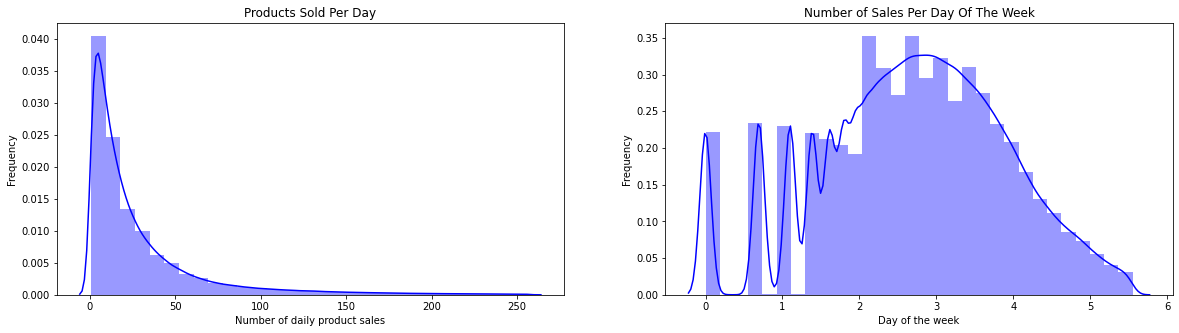

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Blue", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Blue", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("Products Sold Per Day");
ax[1].set_xlabel("Day of the week");
ax[1].set_ylabel("Frequency");
ax[1].set_title("Number of Sales Per Day Of The Week");


## Preparazione dati per il Machine Learning

<center><img width="60%" src="https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F966248982%2F960x0.jpg%3Ffit%3Dscale"></center>

**[Profeta](https://facebook.github.io/prophet/)** di Facebook è l'algoritmo giusto per supportarci nella fase previsionale.

È un modello robusto e semplice da usare, abbastanza potente da fornire buoni risultati.

**Serie storica stazionaria**

Quando si effettuano previsioni con Time Series, è normale preoccuparsi se siano stazionarie o meno.

In [ ]:
# checking the data
df_ts.head()

,AmountSpent
Date,
2018-01-02,485777.8417
2018-01-03,433137.4235
2018-01-04,423442.4813
2018-01-05,399100.5987
2018-01-06,398081.6214


In [ ]:
# importing Prophet
from fbprophet import Prophet
import logging
logging.getLogger().setLevel(logging.ERROR)

#### Lavorare con Prophet

Prophet ha bisogno di un particolare dataframe su cui lavorare. Quello di cui abbiamo bisogno è:
* Colonna della data etichettata "ds"
* Colonna del valore etichettata "y"

In [ ]:
# setting up the dataframe
df_ts = df_ts.reset_index()
df_ts.columns = ['ds', 'y']
df_ts.head()

,ds,y
0,2018-01-02,485777.8417
1,2018-01-03,433137.4235
2,2018-01-04,423442.4813
3,2018-01-05,399100.5987
4,2018-01-06,398081.6214


#### Stationary Test
Valutiamo gli effetti dell'avere una serie temporale stazionaria su cui lavorare con Prophet.

Controlliamo quindi se i nostri dati sono stazionari.

In [ ]:
from statsmodels.tsa.stattools import adfuller
# extracting values
X = df_ts.y

# apply ADF and print results
result = adfuller(X)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result[0]))
print('P Value: {:.10f}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -1.6957
P Value: 0.4333393115
Critical Values:
	1%: -3.4397
	5%: -2.8657
	10%: -2.5690


Il nostro valore P è 0,43, il che significa che la nostra serie storica non è stazionaria.

Vediamo come Prophet affronta la questione per la nostra baseline.

In [ ]:
# setting prediction size to 30 days
prediction_size = 30
train_df = df_ts[:-prediction_size]

In [ ]:
# instantiating the model
b = Prophet()

# training the model
b.fit(train_df)

# make predictions
future = b.make_future_dataframe(periods=prediction_size)

forecast = b.predict(future)

forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,383385.199810,271991.179659,409354.339459,383385.199810,383385.199810,-43472.946887,-43472.946887,-43472.946887,-43472.946887,-43472.946887,-43472.946887,0.0,0.0,0.0,339912.252923
1,2018-01-03,383859.694017,269016.578240,408418.759952,383859.694017,383859.694017,-42876.610461,-42876.610461,-42876.610461,-42876.610461,-42876.610461,-42876.610461,0.0,0.0,0.0,340983.083556
2,2018-01-04,384334.188224,278005.852076,415859.084530,384334.188224,384334.188224,-36855.766814,-36855.766814,-36855.766814,-36855.766814,-36855.766814,-36855.766814,0.0,0.0,0.0,347478.421410
3,2018-01-05,384808.682431,292123.169694,425362.936067,384808.682431,384808.682431,-24640.533419,-24640.533419,-24640.533419,-24640.533419,-24640.533419,-24640.533419,0.0,0.0,0.0,360168.149012
4,2018-01-06,385283.176638,436256.231033,571694.442416,385283.176638,385283.176638,119183.988200,119183.988200,119183.988200,119183.988200,119183.988200,119183.988200,0.0,0.0,0.0,504467.164837


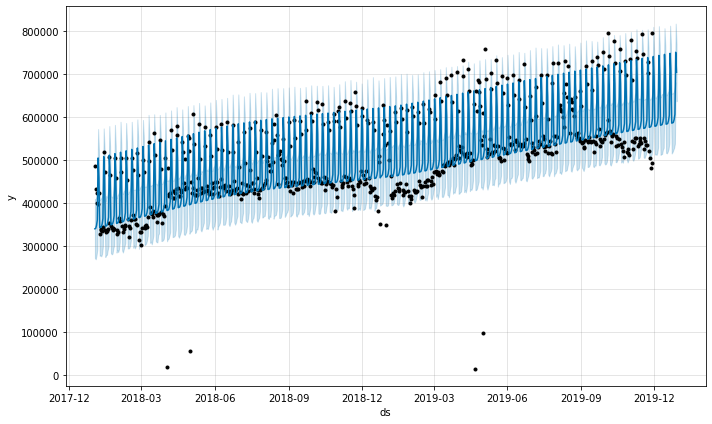

In [ ]:
# plotting the forecast
b.plot(forecast).savefig('forecast_non_stationary.png')

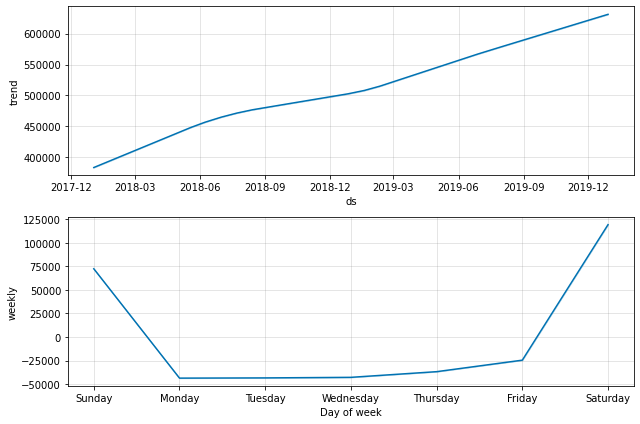

In [ ]:
# plotting components
b.plot_components(forecast).savefig('non_st_components.png')

In [ ]:
# define a function to make a dataframe containing the prediction and actual values
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_ts, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 11.903385518685694
MAE 64045.31615431227


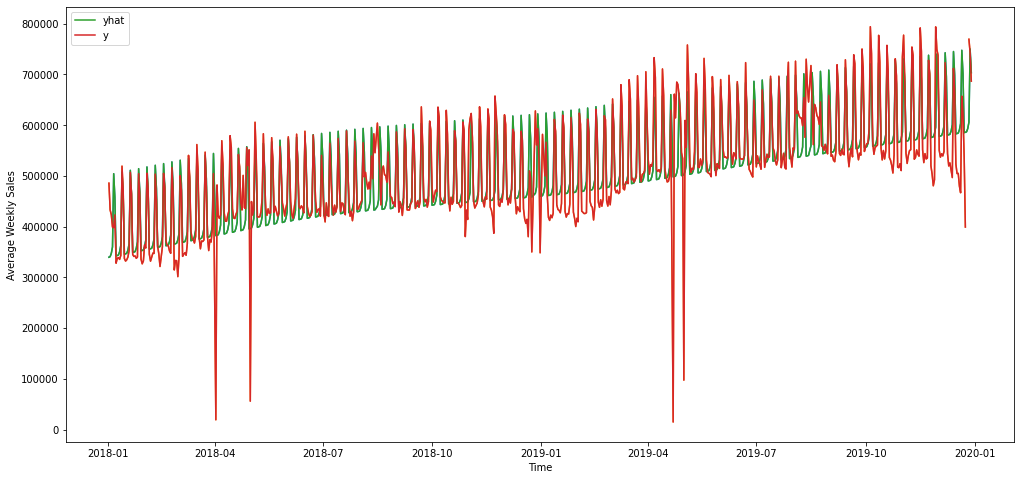

In [ ]:
# checking the results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
#plt.plot(cmp_df['yhat_lower'])
#plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
#ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
#ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.savefig('non_st_yhat.png')
plt.show()

#### Conclusioni
Come facciamo a sapere se le nostre previsioni sono ottimali?

Stiamo utilizzando le metriche per la valutazione:
* Errore percentuale medio assoluto: in che misura le nostre previsioni differiscono dai valori effettivi in percentuale.
* Errore assoluto medio : valore di errore assoluto tra il valore previsto e il valore effettivo.

# Stationary Time Series

Una delle cose che possiamo fare per migliorare i nostri risultati è sicuramente rendere stazionarie le nostre serie temporali e vedere come performano, tutto questo utilizzando una tecnica chiamata **Differencing**.

In [ ]:
# preparing for transformation
df_ts.index = pd.to_datetime(df_ts['ds'], format="%Y-%m-%d")
df_ts.drop('ds', axis=1, inplace=True)
df_ts.head()

,y
ds,
2018-01-02,485777.8417
2018-01-03,433137.4235
2018-01-04,423442.4813
2018-01-05,399100.5987
2018-01-06,398081.6214


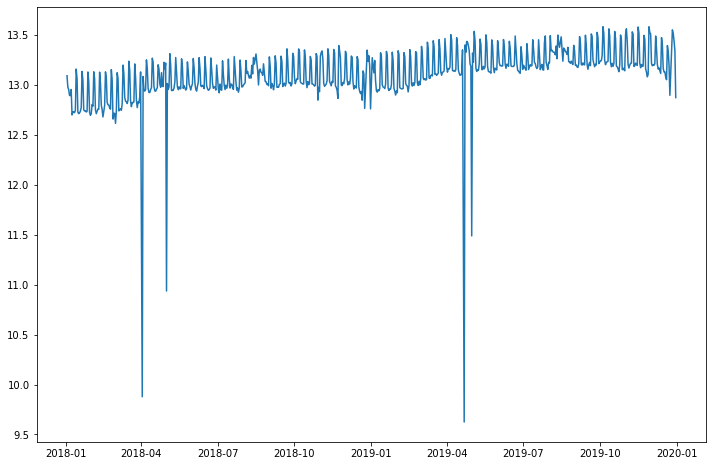

In [ ]:
# log transformation
fig, ax = plt.subplots(figsize=(12,8))
ts_log = np.log(df_ts)
plt.plot(ts_log);

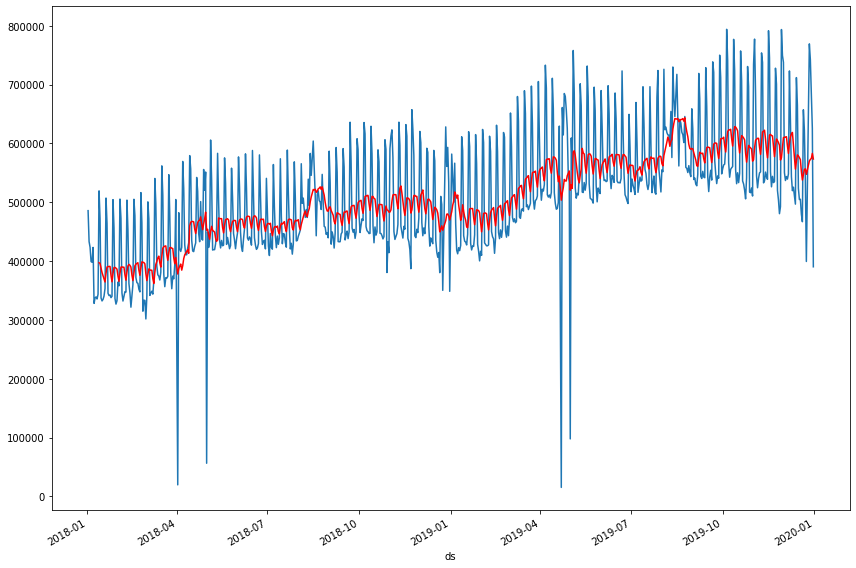

In [ ]:
# checking the original plot
ma = df_ts.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_ts.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout();

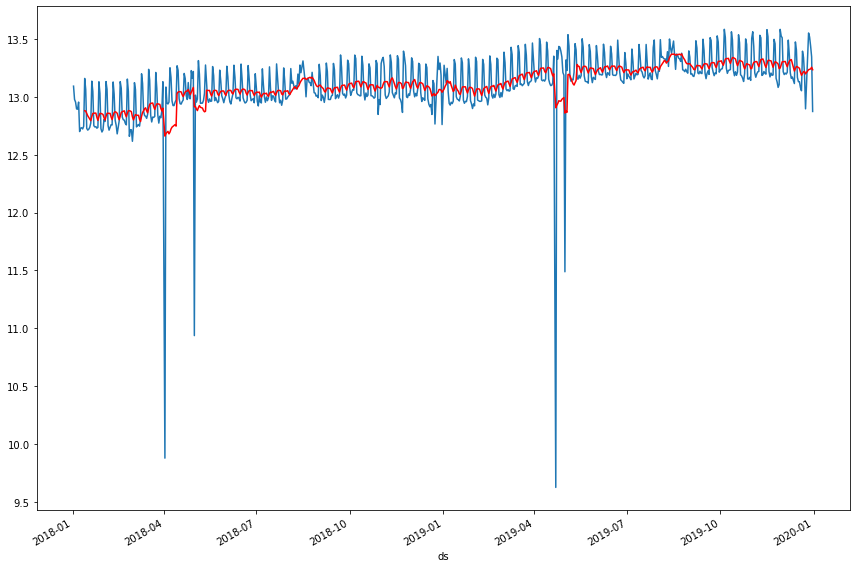

In [ ]:
# applying the log
df_log = np.log(df_ts)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots(figsize=(12,8))
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

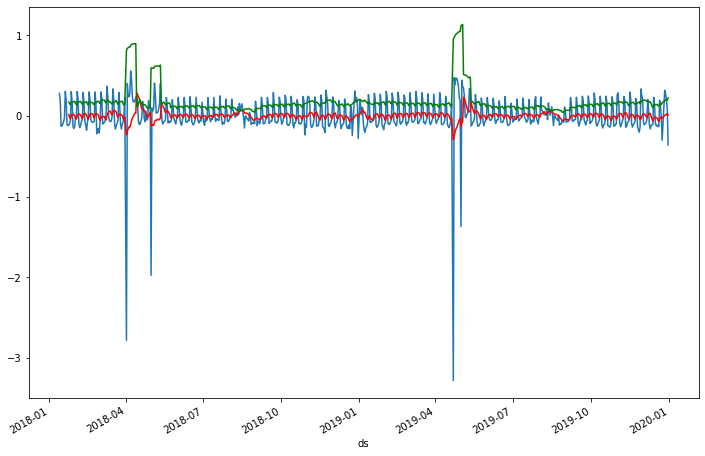

In [ ]:
# subtracting the log average from the data
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show();

In [ ]:
# repeating the ADF
X_sub = df_sub.y.values

# applying ADF and printing the result
result_sub = adfuller(X_sub)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Augmented Dickey–Fuller
Statistical Test: -9.2876
P Value: 0.0000000000
Critical Values:
	1%: -3.4399
	5%: -2.8657
	10%: -2.5690


Con la tecnica del **Differencing** possiamo renderlo ancora migliore e prenderlo come stazionario con un livello di sicurezza ancora più elevato.

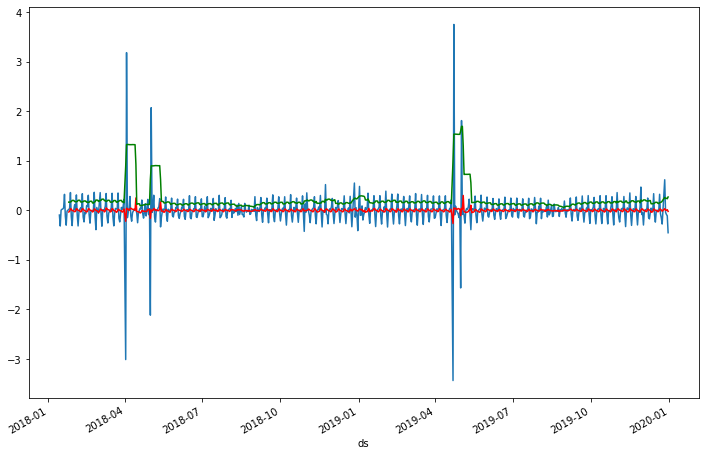

Augmented Dickey–Fuller
Statistical Test: -9.2876
P Value: 0.0000000000
Critical Values:
	1%: -3.4399
	5%: -2.8657
	10%: -2.5690


In [ ]:
# applying differencing
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots(figsize=(12,8))
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extracting values only
X_diff = df_diff.y.dropna().values

# applying ADF and printing the result
result_diff = adfuller(X_diff)
print('Augmented Dickey–Fuller')
print('Statistical Test: {:.4f}'.format(result_sub[0]))
print('P Value: {:.10f}'.format(result_sub[1]))
print('Critical Values:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

#### Lavorare con le Stationary Time Series
Adesso che la Time Series è stazionaria possiamo lavorarci sù.

In [ ]:
# resetting the index to come back to Prophet's format
df_log.reset_index(inplace=True)

In [ ]:
# setting prediction size to 30
prediction_size = 30
train_df = df_log[:-prediction_size]

In [ ]:
# instantiating the model
m = Prophet()

# training the model
m.fit(train_df)

# making predictions
future = m.make_future_dataframe(periods=prediction_size)

forecast = m.predict(future)

forecast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,12.812832,12.468892,12.998780,12.812832,12.812832,-0.085925,-0.085925,-0.085925,-0.085925,-0.085925,-0.085925,0.0,0.0,0.0,12.726907
1,2018-01-03,12.814133,12.462951,13.014590,12.814133,12.814133,-0.079104,-0.079104,-0.079104,-0.079104,-0.079104,-0.079104,0.0,0.0,0.0,12.735029
2,2018-01-04,12.815434,12.476268,13.032294,12.815434,12.815434,-0.059804,-0.059804,-0.059804,-0.059804,-0.059804,-0.059804,0.0,0.0,0.0,12.755630
3,2018-01-05,12.816735,12.520360,13.052152,12.816735,12.816735,-0.036191,-0.036191,-0.036191,-0.036191,-0.036191,-0.036191,0.0,0.0,0.0,12.780545
4,2018-01-06,12.818037,12.769721,13.318932,12.818037,12.818037,0.231177,0.231177,0.231177,0.231177,0.231177,0.231177,0.0,0.0,0.0,13.049213


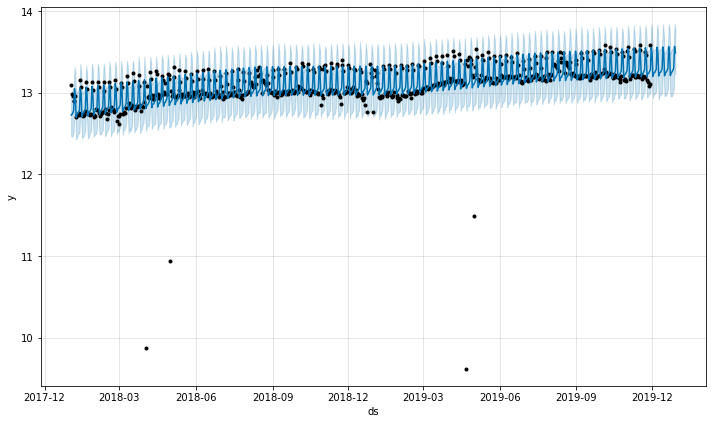

In [ ]:
# plotting the forecast
m.plot(forecast).savefig('st_forecast.png')

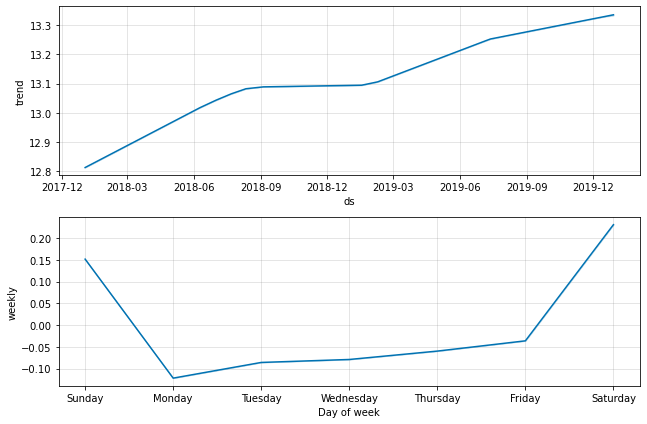

In [ ]:
# plotting components
m.plot_components(forecast).savefig('st_components.png')

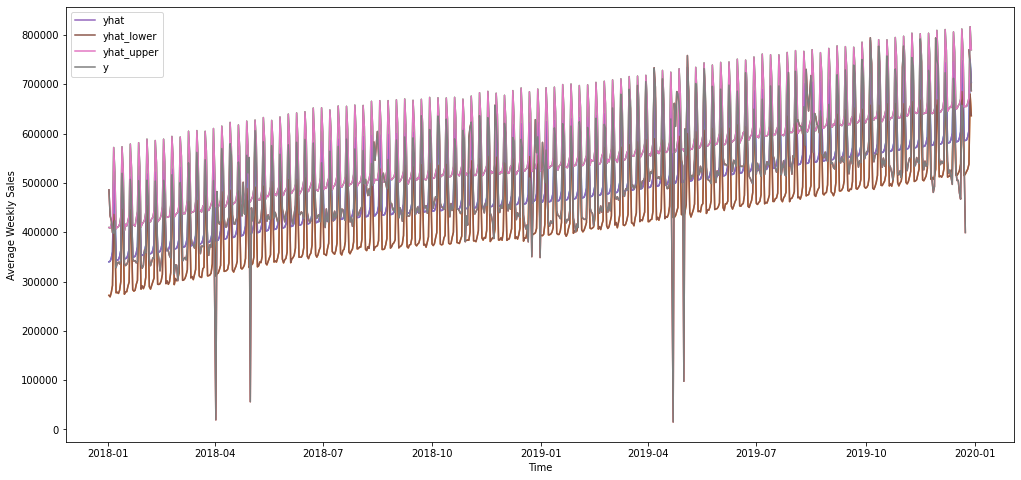

In [ ]:
# checking results
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])

plt.xlabel('Time')
plt.ylabel('Average Weekly Sales')
ax.plot(cmp_df['yhat'], label='yhat')
ax.plot(cmp_df['yhat_lower'], label='yhat_lower')
ax.plot(cmp_df['yhat_upper'], label='yhat_upper')
ax.plot(cmp_df['y'], label='y')
ax.legend()
plt.show()

In [ ]:
# define a function to make a dataframe containing the prediction and actual values
def make_comparison_dataframe(historical, forecast):
  return forecast.set_index('ds')[['yhat', 'yhat_lower',
                                'yhat_upper']].join(historical.set_index('ds'))
cmp_df = make_comparison_dataframe(df_log, forecast)

# define a function to calculate MAPE and MAE
def calculate_forecast_errors(df_ts, prediction_size):

  df = df_ts.copy()
  df['e'] = df['y'] - df['yhat']
  df['p'] = 100 * df['e'] / df['y']
  predicted_part = df[-prediction_size:]

  error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))

  return{'MAPE': error_mean('p'), 'MAE': error_mean('e')}

# print the MAPE and MAE
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
  print(err_name, err_value)

MAPE 0.7626956757590456
MAE 0.10081338190816094


### Conclusioni

Con un MAPE inferiore all'1% ed un MAE di 0,10 è pacifico affermare di aver creato un modello affidabile in ottica predittiva.

E' confermata perciò la potenzialità previsionale su dati stazionari.

Vediamo infine le curve a confronto: **predictions vs reality**!

In [ ]:
# creating a complete dataset
df_final = forecast[['ds', 'yhat']]
df_final.head()

,ds,yhat
0,2018-01-02,12.726907
1,2018-01-03,12.735029
2,2018-01-04,12.755630
3,2018-01-05,12.780545
4,2018-01-06,13.049213


In [ ]:
# visualizing the preditctions as tables
df_final['AmountSpentLog'] = df_log['y']
df_final.head()

,ds,yhat,AmountSpentLog
0,2018-01-02,12.726907,13.093507
1,2018-01-03,12.735029,12.978810
2,2018-01-04,12.755630,12.956173
3,2018-01-05,12.780545,12.896969
4,2018-01-06,13.049213,12.894412


In [ ]:
# getting the values back to their original scale
df_final['AmountSpent'] = np.exp(df_final['AmountSpentLog'].values)
df_final['AmountSpentPred'] = np.exp(df_final['yhat'].values)
df_final.head(10)

,ds,yhat,AmountSpentLog,AmountSpent,AmountSpentPred
0,2018-01-02,12.726907,13.093507,485777.8417,336686.208248
1,2018-01-03,12.735029,12.978810,433137.4235,339432.035873
2,2018-01-04,12.755630,12.956173,423442.4813,346497.172940
3,2018-01-05,12.780545,12.896969,399100.5987,355238.567937
4,2018-01-06,13.049213,12.894412,398081.6214,464730.729026
5,2018-01-07,12.971218,12.955728,423254.2795,429861.481112
6,2018-01-08,12.698606,12.701133,328119.4680,327291.432317
7,2018-01-09,12.736015,12.729395,337525.1151,339766.897525
8,2018-01-10,12.744137,12.734085,339111.6185,342537.849559
9,2018-01-11,12.764738,12.723673,335599.3020,349667.632850


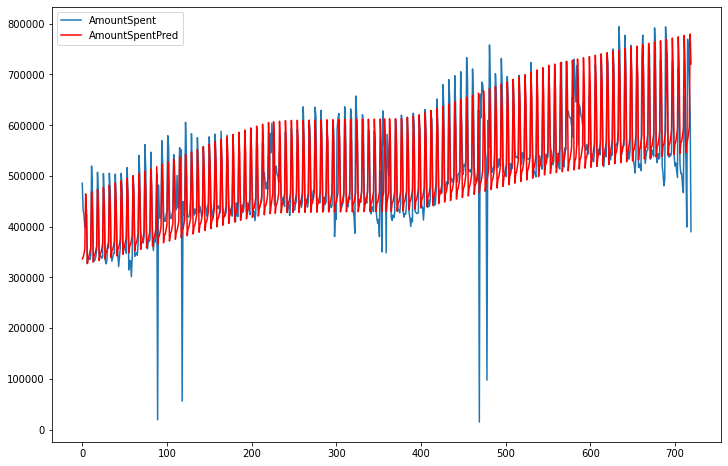

In [ ]:
# plotting predictions vs reality
fig, ax = plt.subplots(figsize=(12,8))
df_final['AmountSpent'].plot(ax=ax, legend=('Amount Spent'))
df_final['AmountSpentPred'].plot(ax=ax, color='r', legend={'Predicted'})
plt.savefig('st_yhat.png')
plt.show()


# Thank You!
